fractional errors at: 0.288344080048 0.3705861774 0.998882536316
f: 0.0634069284696 -0.00509659292498 0.0685035213946
fractional errors at: 0.521922596083 0.822996255499 0.849314389071
f: 0.176241567146 0.360644324716 -0.18440275757
fractional errors at: 0.685796359057 0.0343394115374 0.0535006494251
f: 0.0749803130638 -0.00483430709217 0.079814620156
fractional errors at: 0.0845225718294 0.816354227286 0.91442704712
f: 0.0117001725942 0.0169843853301 -0.00528421273595
fractional errors at: 0.709809364679 0.0371831714208 0.530679530326
f: 0.147729982899 0.133257224766 0.0144727581331
fractional errors at: 0.369753165005 0.661099230441 0.141124468091
f: 0.525054221645 0.516774504514 0.00827971713095
fractional errors at: 0.860666646487 0.451124628371 0.979781339566
f: 0.0322519913582 0.0172650202265 0.0149869711317
fractional errors at: 0.542053211616 0.683608065506 0.937549472087
f: 0.176047955593 -0.014591194989 0.190639150582
fractional errors at: 0.546703365273 0.165203898029 0.4887

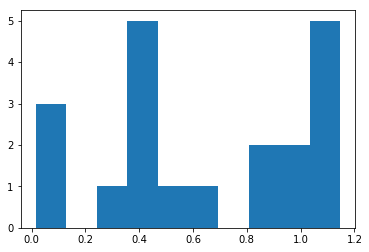

In [9]:
'''Based on the paper doi=10.1.1.89.7835
the tricubic interpolation of a regular possibly non uniform grid can be seen as a computation of 21 cubic splines.
A cubic spline is a special case of cubic interpolation, and in general these 21 cubic splines perform many redundant
calulations. Here we formulate the full tricubic interpolation where the value of a scalar function defined on a 3d
grid can be reconstructed to allow full C1, and thus langrangian structures to persist.'''

import numpy as np
import h5py

class TriCubic(object):
    def __init__(self,xvec=None,yvec=None,zvec=None,M=None,useCache = True,default=None, filename=None):
        '''Object that handles tri cubic interpolation. In general use the following parameters:
        ``xvec`` - the xaxis (regular)
        ``yvec`` - the yaxis (regular)
        ``zvec`` - the zaxis (regular)
        ``M`` - the array of shape (len(xvec),len(yvec),len(zvec)) to be interpolated
                ``M`` will be transformed to a flat vector, member ``m``. This can be replaced and clearCache called.
        ``useCache`` - whether to save interpolants (keep yes for efficiency when interpolants used often).
        ``default`` - when point falls out of domain specified by xvec,yvec, zvec what value to return,
                    None (default) means nearest.
        ``pad`` - whether to pad array (experimental: leave False)'''
        if filename is not None:
            self.load(filename,useCache=useCache,default=default)
            return
        self.default = default
        self.nx = np.size(xvec)
        self.ny = np.size(yvec)
        self.nz = np.size(zvec)
        self.xvec = xvec.ravel(order='C')
        self.yvec = yvec.ravel(order='C')
        self.zvec = zvec.ravel(order='C')
        self.m = M.ravel(order='C')
        self.setBinv()
        self.checkIndexing(M)
        self.useCache = useCache
        if self.useCache:
            self.cache = {}
            #self.cacheCount = np.zeros(self.nx*self.ny*self.nz,dtype=np.double)
        else:
            self.cache = None
            self.cacheCount = None
        #print(self.iPowers,self.jPowers,self.kPowers)
    
    def copy(self,**kwargs):
        '''Return a copy of the TriCubic object by essentially creating a copy of all the data. 
        ``kwargs`` are the same as constructor.'''
        return TriCubic(self.xvec.copy(),self.yvec.copy(),self.zvec.copy(),self.getShapedArray().copy(),**kwargs)
    def load(self,filename,**kwargs):
        f = h5py.File(filename,'r')
        xvec = f["TCI/xvec"][:]
        yvec = f["TCI/yvec"][:]
        zvec = f["TCI/zvec"][:]
        M = f["TCI/M"][:,:,:]
        self.__init__(xvec,yvec,zvec,M,**kwargs)
        f.close()
    #@jit
    def save(self,filename):
        dt = h5py.special_dtype(vlen=str)
        f = h5py.File(filename,'w')
        xvec = f.create_dataset("TCI/xvec",(self.nx,),dtype=np.double)
        yvec = f.create_dataset("TCI/yvec",(self.ny,),dtype=np.double)
        zvec = f.create_dataset("TCI/zvec",(self.nz,),dtype=np.double)
        M = f.create_dataset("TCI/M",(self.nx,self.ny,self.nz),dtype=np.double)
        xvec[...] = self.xvec
        yvec[...] = self.yvec
        zvec[...] = self.zvec
        M[...] = self.getShapedArray()
        f.close()
    def clearCache(self):
        '''Clear the cache, which should be done if overwriting the array'''
        self.cache = {}
    
    def bisection(self,array,value):
        '''Given an ``array`` , and given a ``value`` , returns an index j such that ``value`` is between array[j]
        and array[j+1]. ``array`` must be monotonic increasing. j=-1 or j=len(array) is returned
        to indicate that ``value`` is out of range below and above respectively.'''
        #return bisection(array,value)
        n = len(array)
        if (value < array[0]):
            return -1
            res = -1# Then set the output
        elif (value > array[n-1]):
            return n
        #array = np.append(np.append(-np.inf,array),np.inf)
        jl = 0# Initialize lower
        ju = n-1# and upper limits.
        while (ju-jl > 1):# If we are not yet done,
            jm=(ju+jl) >> 1# compute a midpoint,
            if (value >= array[jm]):
                jl=jm# and replace either the lower limit
            else:
                ju=jm# or the upper limit, as appropriate.
            # Repeat until the test condition is satisfied.
        if (value == array[0]):
            return 0
            res = -1# Then set the output
        elif (value == array[n-1]):
            return n-1
        else:
            return jl
    
    def getInterpIndex(self,x,y,z):
        '''vectorized find closest cell rounding down always'''
        xi = self.bisection(self.xvec,x)
        yi = self.bisection(self.yvec,y)
        zi = self.bisection(self.zvec,z)
        assert xi > 1 and xi < self.nx - 2, "x index {} on boundary!".format(xi)
        assert yi > 1 and yi < self.ny - 2, "y index {} on boundary!".format(yi)
        assert zi > 1 and zi < self.nz - 2, "z index {} on boundary!".format(zi)
        return xi,yi,zi

    
    def index(self,i,j,k):
        '''Correct indexing of 3-tensor in ravelled vector, vectorized'''
        return k + self.nz*(j + self.ny*i)
        
    def getShapedArray(self):
        '''Return the model in 3d array with proper ij ordering'''
        return self.m.reshape(self.nx,self.ny,self.nz,order='C')
    def getModelCoordinates(self):
        X,Y,Z = np.meshgrid(self.xvec,self.yvec,self.zvec,indexing='ij')
        return X.ravel(order='C'),Y.ravel(order='C'),Z.ravel(order='C')
        
    def checkIndexing(self,M,N=100):
        '''Check that ordering of elements is correct'''
        assert not np.any(np.isnan(M)), "M contains nans"
        N = min(N,np.size(self.m))
        idx = 0
        while idx < N:
            i = np.random.randint(self.nx)
            j = np.random.randint(self.ny)
            k = np.random.randint(self.nz)
            assert self.m[self.index(i,j,k)] == M[i,j,k], "Ordering of indexing is wrong, m[{},{},{}] != {}, M[{},{},{}] = {}".format(i,j,k,self.m[self.index(i,j,k)],i,j,k,M[i,j,k])
            idx += 1
        assert np.alltrue(self.getShapedArray() == M), "reshape is not right"
        return True
    
    def getInterpolant(self,x,y,z):
        '''vectorized build the interpolant'''
        xi,yi,zi = self.getInterpIndex(x,y,z)
        
        #print(xi,yi,zi)
        ijk = self.index(xi,yi,zi)#bottom corner of cube
        if self.useCache:
            if ijk in self.cache.keys():
                A_ijk = self.cache[ijk]
            else:
                b = self.get_bVec(xi,yi,zi)
                A_ijk = self.Binv.dot(b).ravel()
            self.cache[ijk] = A_ijk
            #self.cacheCount[ijk] += 1
        else:
            b = self.get_bVec(xi,yi,zi)
            A_ijk = self.Binv.dot(b).ravel()
        return xi,yi,zi,A_ijk
    
    def interp(self,x,y,z,doDiff=False):
        '''Interpolate and return f,fx,fy,fz if doDouble is True then return also fxy,fxz, fyz.
        Double derivatives do not yet work I think.'''
        
        #xi,yi,zi,A_ijk = self.getInterpolant(x,y,z)
        xi,yi,zi = self.getInterpIndex(x,y,z)
        ijk = self.index(xi,yi,zi)
        return self.m[ijk]
        u = (x - self.xvec[xi])/(self.xvec[xi+1] - self.xvec[xi])
        v = (y - self.yvec[yi])/(self.yvec[yi+1] - self.yvec[yi])
        w = (z - self.zvec[zi])/(self.zvec[zi+1] - self.zvec[zi])
        #print(u,v,w)
        x,y,z = u,v,w
        x0 = z**2
        x1 = z**3
        x2 = y*z
        x3 = x0*y
        x4 = x1*y
        x5 = y**2
        x6 = x5*z
        x7 = x0*x5
        x8 = x1*x5
        x9 = y**3
        x10 = x9*z
        x11 = x0*x9
        x12 = x1*x9
        x13 = x*z
        x14 = x*x0
        x15 = x*x1
        x16 = x*y
        x17 = x16*z
        x18 = x0*x16
        x19 = x*x5
        x20 = x13*x5
        x21 = x0*x19
        x22 = x*x9
        x23 = x0*x22
        x24 = x**2
        x25 = x24*z
        x26 = x0*x24
        x27 = x1*x24
        x28 = x24*y
        x29 = x2*x24
        x30 = x0*x28
        x31 = x24*x5
        x32 = x25*x5
        x33 = x0*x31
        x34 = x24*x9
        x35 = x0*x34
        x36 = x**3
        x37 = x36*z
        x38 = x0*x36
        x39 = x1*x36
        x40 = x36*y
        x41 = x0*x40
        x42 = x36*x5
        x43 = x37*x5
        x44 = x0*x42
        x45 = x36*x9
        x46 = 2*x
        x47 = x46*z
        x48 = x0*x46
        x49 = x1*x46
        x50 = x46*y
        x51 = x2*x46
        x52 = x0*x50
        x53 = x1*x50
        x54 = x46*x5
        x55 = x47*x5
        x56 = x46*x9
        x57 = x47*x9
        x58 = 3*x24
        x59 = x58*z
        x60 = x0*x58
        x61 = x1*x58
        x62 = x58*y
        x63 = x3*x58
        x64 = x5*x58
        x65 = x58*x6
        x66 = x58*x7
        x67 = x58*x8
        x68 = x58*x9
        x69 = x11*x58
        x70 = 2*y
        x71 = x70*z
        x72 = x0*x70
        x73 = x1*x70
        x74 = 3*x5
        x75 = x74*z
        x76 = x0*x74
        x77 = x1*x74
        x78 = x*x74
        x79 = x14*x74
        x80 = x24*x70
        x81 = x24*x71
        x82 = x36*x70
        x83 = x36*x71
        x84 = x36*x74
        x85 = x38*x74
        x86 = 2*z
        x87 = 3*x0
        x88 = x87*y
        x89 = x5*x86
        x90 = x86*x9
        x91 = x87*x9
        x92 = x*x87
        x93 = x24*x86
        x94 = x36*x86
        x95 = x36*x87
        x96 = 4*x16
        x97 = x96*z
        x98 = 6*x19
        x99 = 6*x20
        x100 = x0*x98
        x101 = 6*x28
        x102 = 6*x29
        x103 = x0*x101
        x104 = 9*x31
        x105 = x0*x104
        x106 = 4*x13
        x107 = 6*x14
        x108 = 6*x18
        x109 = 6*x25
        x110 = 9*x26
        x111 = x109*x5
        x112 = 4*x2
        x113 = 6*x3
        x114 = 6*x6
        x115 = 9*x7
        B = np.array([[1, z, x0, x1, y, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x, x13, x14, x15, x16, x17, x18, x1*x16, x19, x20, x21, x1*x19, x22, x13*x9, x23, x1*x22, x24, x25, x26, x27, x28, x29, x30, x1*x28, x31, x32, x33, x1*x31, x34, x25*x9, x35, x1*x34, x36, x37, x38, x39, x40, x2*x36, x41, x1*x40, x42, x43, x44, x1*x42, x45, x37*x9, x0*x45, x1*x45], 
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, z, x0, x1, y, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x46, x47, x48, x49, x50, x51, x52, x53, x54, x55, x0*x54, x1*x54, x56, x57, x0*x56, x1*x56, x58, x59, x60, x61, x62, x2*x58, x63, x4*x58, x64, x65, x66, x67, x68, x10*x58, x69, x12*x58],
                  [0, 0, 0, 0, 1, z, x0, x1, x70, x71, x72, x73, x74, x75, x76, x77, 0, 0, 0, 0, x, x13, x14, x15, x50, x51, x52, x53, x78, x13*x74, x79, x15*x74, 0, 0, 0, 0, x24, x25, x26, x27, x80, x81, x0*x80, x1*x80, x64, x65, x66, x67, 0, 0, 0, 0, x36, x37, x38, x39, x82, x83, x0*x82, x1*x82, x84, x37*x74, x85, x39*x74], 
                  [0, 1, x86, x87, 0, y, x71, x88, 0, x5, x89, x76, 0, x9, x90, x91, 0, x, x47, x92, 0, x16, x51, x16*x87, 0, x19, x55, x79, 0, x22, x57, x22*x87, 0, x24, x93, x60, 0, x28, x81, x63, 0, x31, x5*x93, x66, 0, x34, x9*x93, x69, 0, x36, x94, x95, 0, x40, x83, x40*x87, 0, x42, x5*x94, x85, 0, x45, x9*x94, x45*x87],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, z, x0, x1, x70, x71, x72, x73, x74, x75, x76, x77, 0, 0, 0, 0, x46, x47, x48, x49, x96, x97, x0*x96, x1*x96, x98, x99, x100, x1*x98, 0, 0, 0, 0, x58, x59, x60, x61, x101, x102, x103, x1*x101, x104, 9*x32, x105, x1*x104], 
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, x86, x87, 0, y, x71, x88, 0, x5, x89, x76, 0, x9, x90, x91, 0, x46, x106, x107, 0, x50, x97, x108, 0, x54, x106*x5, x100, 0, x56, x106*x9, 6*x23, 0, x58, x109, x110, 0, x62, x102, 9*x30, 0, x64, x111, x105, 0, x68, x109*x9, 9*x35], 
                  [0, 0, 0, 0, 0, 1, x86, x87, 0, x70, x112, x113, 0, x74, x114, x115, 0, 0, 0, 0, 0, x, x47, x92, 0, x50, x97, x108, 0, x78, x99, 9*x21, 0, 0, 0, 0, 0, x24, x93, x60, 0, x80, x112*x24, x103, 0, x64, x111, x105, 0, 0, 0, 0, 0, x36, x94, x95, 0, x82, x112*x36, 6*x41, 0, x84, 6*x43, 9*x44],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, x86, x87, 0, x70, x112, x113, 0, x74, x114, x115, 0, 0, 0, 0, 0, x46, x106, x107, 0, x96, 8*x17, 12*x18, 0, x98, 12*x20, 18*x21, 0, 0, 0, 0, 0, x58, x109, x110, 0, x101, 12*x29, 18*x30, 0, x104, 18*x32, 27*x33]],
                 dtype=np.double)
        bvec = B.dot(A_ijk)
        if doDiff:
            return bvec
        else:
            return bvec[0]
    
    def get_m(self,idx):
        return self.m[np.int64(idx)]
    
    def get_xvec(self,i):
        return self.xvec[np.int64(i)]
    
    def get_yvec(self,j):
        return self.yvec[np.int64(j)]
    
    def get_zvec(self,k):
        return self.zvec[np.int64(k)]
    
    def get_bVec(self,i,j,k):
        nx = self.nx
        ny = self.ny
        nz = self.nz
        x0 = ny*i
        x1 = x0 + j
        x2 = nz*x1
        x3 = x2 + k
        x4 = self.get_m(x3)
        x5 = i - 1.0
        x6 = self.get_xvec(x5)
        x7 = i + 1.0
        x8 = self.get_xvec(x7)
        x9 = 1/(x6 - x8)
        x10 = 0.166666666666667*x9
        x11 = ny*(i - 2.0)
        x12 = x11 + j
        x13 = nz*x12
        x14 = x13 + k
        x15 = self.get_m(x14)
        x16 = ny*x5
        x17 = x16 + j
        x18 = nz*x17
        x19 = x18 + k
        x20 = self.get_m(x19)
        x21 = -8.0*x20
        x22 = ny*x7
        x23 = x22 + j
        x24 = nz*x23
        x25 = x24 + k
        x26 = self.get_m(x25)
        x27 = 8.0*x26
        x28 = i + 2.0
        x29 = ny*x28
        x30 = x29 + j
        x31 = nz*x30
        x32 = x31 + k
        x33 = self.get_m(x32)
        x34 = j - 1.0
        x35 = j + 1.0
        x36 = 1/(self.get_yvec(x34) - self.get_yvec(x35))
        x37 = 0.166666666666667*x36
        x38 = nz*(x1 - 2.0)
        x39 = x38 + k
        x40 = self.get_m(x39)
        x41 = nz*(x0 + x34)
        x42 = x41 + k
        x43 = self.get_m(x42)
        x44 = -8.0*x43
        x45 = nz*(x0 + x35)
        x46 = x45 + k
        x47 = self.get_m(x46)
        x48 = 8.0*x47
        x49 = j + 2.0
        x50 = nz*(x0 + x49)
        x51 = x50 + k
        x52 = self.get_m(x51)
        x53 = k - 1.0
        x54 = k + 1.0
        x55 = 1/(self.get_zvec(x53) - self.get_zvec(x54))
        x56 = 0.166666666666667*x55
        x57 = self.get_m(x3 - 2)
        x58 = self.get_m(x2 + x53)
        x59 = -8.0*x58
        x60 = self.get_m(x2 + x54)
        x61 = 8.0*x60
        x62 = k + 2.0
        x63 = self.get_m(x2 + x62)
        x64 = 0.0277777777777778*x36*x9
        x65 = nz*(x11 + x34)
        x66 = x65 + k
        x67 = self.get_m(x66)
        x68 = -8.0*x67
        x69 = nz*(x16 + x34)
        x70 = x69 + k
        x71 = self.get_m(x70)
        x72 = 64.0*x71
        x73 = nz*(x22 + x34)
        x74 = x73 + k
        x75 = self.get_m(x74)
        x76 = 64.0*x75
        x77 = -x76
        x78 = nz*(x12 - 2.0)
        x79 = x78 + k
        x80 = self.get_m(x79)
        x81 = nz*(x29 + x49)
        x82 = x81 + k
        x83 = self.get_m(x82)
        x84 = nz*(x11 + x35)
        x85 = x84 + k
        x86 = self.get_m(x85)
        x87 = 8.0*x86
        x88 = nz*(x11 + x49)
        x89 = x88 + k
        x90 = self.get_m(x89)
        x91 = nz*(x17 - 2.0)
        x92 = x91 + k
        x93 = self.get_m(x92)
        x94 = 8.0*x93
        x95 = nz*(x16 + x35)
        x96 = x95 + k
        x97 = self.get_m(x96)
        x98 = 64.0*x97
        x99 = nz*(x16 + x49)
        x100 = x99 + k
        x101 = self.get_m(x100)
        x102 = 8.0*x101
        x103 = nz*(x23 - 2.0)
        x104 = x103 + k
        x105 = self.get_m(x104)
        x106 = 8.0*x105
        x107 = nz*(x22 + x35)
        x108 = x107 + k
        x109 = self.get_m(x108)
        x110 = 64.0*x109
        x111 = nz*(x22 + x49)
        x112 = x111 + k
        x113 = self.get_m(x112)
        x114 = 8.0*x113
        x115 = -x114
        x116 = nz*(x30 - 2.0)
        x117 = x116 + k
        x118 = self.get_m(x117)
        x119 = nz*(x29 + x34)
        x120 = x119 + k
        x121 = self.get_m(x120)
        x122 = 8.0*x121
        x123 = nz*(x29 + x35)
        x124 = x123 + k
        x125 = self.get_m(x124)
        x126 = 8.0*x125
        x127 = -x126
        x128 = 0.0277777777777778*x55*x9
        x129 = self.get_m(x19 - 2)
        x130 = -8.0*x129
        x131 = self.get_m(x18 + x53)
        x132 = 64.0*x131
        x133 = self.get_m(x18 + x54)
        x134 = 64.0*x133
        x135 = -x134
        x136 = self.get_m(x14 - 2)
        x137 = self.get_m(x31 + x62)
        x138 = self.get_m(x13 + x53)
        x139 = -8.0*x138
        x140 = self.get_m(x13 + x54)
        x141 = 8.0*x140
        x142 = self.get_m(x13 + x62)
        x143 = self.get_m(x18 + x62)
        x144 = 8.0*x143
        x145 = self.get_m(x25 - 2)
        x146 = 8.0*x145
        x147 = self.get_m(x24 + x53)
        x148 = -64.0*x147
        x149 = self.get_m(x24 + x54)
        x150 = 64.0*x149
        x151 = self.get_m(x24 + x62)
        x152 = -8.0*x151
        x153 = self.get_m(x32 - 2)
        x154 = self.get_m(x31 + x53)
        x155 = 8.0*x154
        x156 = self.get_m(x31 + x54)
        x157 = 8.0*x156
        x158 = -x157
        x159 = 0.0277777777777778*x36*x55
        x160 = self.get_m(x42 - 2)
        x161 = -8.0*x160
        x162 = self.get_m(x41 + x53)
        x163 = 64.0*x162
        x164 = self.get_m(x39 - 2)
        x165 = self.get_m(x50 + x62)
        x166 = self.get_m(x38 + x53)
        x167 = 8.0*x166
        x168 = self.get_m(x38 + x54)
        x169 = 8.0*x168
        x170 = self.get_m(x38 + x62)
        x171 = self.get_m(x41 + x54)
        x172 = -64.0*x171
        x173 = self.get_m(x41 + x62)
        x174 = 8.0*x173
        x175 = self.get_m(x46 - 2)
        x176 = 8.0*x175
        x177 = self.get_m(x45 + x53)
        x178 = 64.0*x177
        x179 = -x178
        x180 = self.get_m(x45 + x54)
        x181 = 64.0*x180
        x182 = self.get_m(x45 + x62)
        x183 = -8.0*x182
        x184 = self.get_m(x51 - 2)
        x185 = self.get_m(x50 + x53)
        x186 = 8.0*x185
        x187 = self.get_m(x50 + x54)
        x188 = -8.0*x187
        x189 = x55*x9
        x190 = self.get_m(x62 + x91)
        x191 = self.get_m(x62 + x69)
        x192 = 64.0*x191
        x193 = self.get_m(x62 + x99)
        x194 = 8.0*x193
        x195 = self.get_m(x116 + x53)
        x196 = self.get_m(x119 + x53)
        x197 = 64.0*x196
        x198 = self.get_m(x123 + x53)
        x199 = 64.0*x198
        x200 = self.get_m(x53 + x81)
        x201 = 8.0*x200
        x202 = -8.0*x190 + x192 + x194 - 8.0*x195 + x197 - x199 + x201
        x203 = self.get_m(x62 + x78)
        x204 = self.get_m(x89 - 2)
        x205 = self.get_m(x117 - 2)
        x206 = self.get_m(x62 + x81)
        x207 = self.get_m(x53 + x78)
        x208 = self.get_m(x54 + x78)
        x209 = self.get_m(x66 - 2)
        x210 = self.get_m(x53 + x65)
        x211 = self.get_m(x54 + x65)
        x212 = self.get_m(x62 + x65)
        x213 = 8.0*x212
        x214 = self.get_m(x85 - 2)
        x215 = self.get_m(x53 + x84)
        x216 = self.get_m(x54 + x84)
        x217 = self.get_m(x62 + x84)
        x218 = 8.0*x217
        x219 = self.get_m(x53 + x88)
        x220 = 8.0*x219
        x221 = self.get_m(x54 + x88)
        x222 = 8.0*x221
        x223 = self.get_m(x62 + x88)
        x224 = self.get_m(x92 - 2)
        x225 = self.get_m(x53 + x91)
        x226 = self.get_m(x54 + x91)
        x227 = self.get_m(x70 - 2)
        x228 = self.get_m(x53 + x69)
        x229 = self.get_m(x54 + x69)
        x230 = self.get_m(x96 - 2)
        x231 = self.get_m(x53 + x95)
        x232 = self.get_m(x54 + x95)
        x233 = self.get_m(x62 + x95)
        x234 = -64.0*x233
        x235 = self.get_m(x100 - 2)
        x236 = 8.0*x235
        x237 = self.get_m(x53 + x99)
        x238 = 64.0*x237
        x239 = self.get_m(x54 + x99)
        x240 = 64.0*x239
        x241 = -x240
        x242 = self.get_m(x104 - 2)
        x243 = self.get_m(x103 + x53)
        x244 = self.get_m(x103 + x54)
        x245 = self.get_m(x103 + x62)
        x246 = 8.0*x245
        x247 = self.get_m(x74 - 2)
        x248 = self.get_m(x53 + x73)
        x249 = self.get_m(x54 + x73)
        x250 = self.get_m(x62 + x73)
        x251 = 64.0*x250
        x252 = -x251
        x253 = self.get_m(x108 - 2)
        x254 = self.get_m(x107 + x53)
        x255 = self.get_m(x107 + x54)
        x256 = self.get_m(x107 + x62)
        x257 = 64.0*x256
        x258 = self.get_m(x112 - 2)
        x259 = 8.0*x258
        x260 = self.get_m(x111 + x53)
        x261 = 64.0*x260
        x262 = self.get_m(x111 + x54)
        x263 = 64.0*x262
        x264 = self.get_m(x111 + x62)
        x265 = 8.0*x264
        x266 = -x265
        x267 = self.get_m(x116 + x54)
        x268 = 8.0*x267
        x269 = self.get_m(x116 + x62)
        x270 = self.get_m(x120 - 2)
        x271 = 8.0*x270
        x272 = self.get_m(x119 + x54)
        x273 = 64.0*x272
        x274 = self.get_m(x119 + x62)
        x275 = 8.0*x274
        x276 = self.get_m(x124 - 2)
        x277 = 8.0*x276
        x278 = self.get_m(x123 + x54)
        x279 = 64.0*x278
        x280 = self.get_m(x123 + x62)
        x281 = 8.0*x280
        x282 = -x281
        x283 = self.get_m(x82 - 2)
        x284 = self.get_m(x54 + x81)
        x285 = 8.0*x284
        x286 = -x285
        x287 = -8.0*x133
        x288 = 8.0*x149
        x289 = -8.0*x171
        x290 = 8.0*x180
        x291 = 1/(-self.get_zvec(x62) + self.get_zvec(k))
        x292 = 0.166666666666667*x291
        x293 = self.get_m(x3 + 3)
        x294 = 8.0*x4
        x295 = -8.0*x63
        x296 = -8.0*x226
        x297 = 64.0*x229
        x298 = 8.0*x211
        x299 = 8.0*x216
        x300 = -64.0*x232
        x301 = 8.0*x239
        x302 = 8.0*x244
        x303 = 64.0*x249
        x304 = -x303
        x305 = 64.0*x255
        x306 = -8.0*x262
        x307 = 8.0*x272
        x308 = -8.0*x278
        x309 = 0.0277777777777778*x291*x9
        x310 = 8.0*x142
        x311 = 64.0*x151
        x312 = 8.0*x137
        x313 = -x312
        x314 = self.get_m(x32 + 3)
        x315 = -8.0*x15
        x316 = 64.0*x20
        x317 = 64.0*x26
        x318 = -x317
        x319 = 8.0*x33
        x320 = self.get_m(x14 + 3)
        x321 = 8.0*x131
        x322 = -x321
        x323 = -64.0*x143
        x324 = self.get_m(x19 + 3)
        x325 = 8.0*x324
        x326 = 8.0*x147
        x327 = self.get_m(x25 + 3)
        x328 = 8.0*x327
        x329 = 0.0277777777777778*x291*x36
        x330 = 64.0*x43
        x331 = 8.0*x162
        x332 = -x331
        x333 = 64.0*x173
        x334 = -x333
        x335 = self.get_m(x42 + 3)
        x336 = 8.0*x335
        x337 = self.get_m(x51 + 3)
        x338 = 8.0*x40
        x339 = 64.0*x47
        x340 = 8.0*x52
        x341 = 8.0*x170
        x342 = self.get_m(x39 + 3)
        x343 = 8.0*x177
        x344 = 64.0*x182
        x345 = self.get_m(x46 + 3)
        x346 = 8.0*x345
        x347 = 8.0*x165
        x348 = 0.00462962962962963*x291*x36
        x349 = 64.0*x228
        x350 = 8.0*x237
        x351 = 64.0*x274
        x352 = 8.0*x206
        x353 = 8.0*x225 + 8.0*x269 - x349 - x350 - x351 - x352
        x354 = self.get_m(x82 + 3)
        x355 = 8.0*x90
        x356 = 64.0*x101
        x357 = 64.0*x113
        x358 = -x357
        x359 = -8.0*x118
        x360 = 64.0*x121
        x361 = -64.0*x125
        x362 = 8.0*x83
        x363 = 8.0*x210
        x364 = self.get_m(x66 + 3)
        x365 = -8.0*x215
        x366 = self.get_m(x85 + 3)
        x367 = 8.0*x223
        x368 = self.get_m(x89 + 3)
        x369 = self.get_m(x92 + 3)
        x370 = self.get_m(x70 + 3)
        x371 = 64.0*x231
        x372 = self.get_m(x96 + 3)
        x373 = 64.0*x193
        x374 = self.get_m(x100 + 3)
        x375 = 8.0*x374
        x376 = -8.0*x243
        x377 = self.get_m(x104 + 3)
        x378 = 64.0*x248
        x379 = self.get_m(x74 + 3)
        x380 = -64.0*x254
        x381 = self.get_m(x108 + 3)
        x382 = 8.0*x260
        x383 = 64.0*x264
        x384 = self.get_m(x112 + 3)
        x385 = -8.0*x384
        x386 = self.get_m(x117 + 3)
        x387 = 8.0*x196
        x388 = self.get_m(x120 + 3)
        x389 = 8.0*x388
        x390 = 8.0*x198
        x391 = 64.0*x280
        x392 = self.get_m(x124 + 3)
        x393 = -8.0*x392
        x394 = -8.0*x97
        x395 = 8.0*x109
        x396 = 1/(-self.get_yvec(x49) + self.get_yvec(j))
        x397 = 0.166666666666667*x396
        x398 = nz*(x1 + 3.0)
        x399 = x398 + k
        x400 = self.get_m(x399)
        x401 = -x340
        x402 = -x343
        x403 = 0.0277777777777778*x396*x9
        x404 = 8.0*x71
        x405 = -x404
        x406 = -x356
        x407 = nz*(x17 + 3.0)
        x408 = x407 + k
        x409 = self.get_m(x408)
        x410 = 8.0*x409
        x411 = nz*(x30 + 3.0)
        x412 = x411 + k
        x413 = self.get_m(x412)
        x414 = nz*(x12 + 3.0)
        x415 = x414 + k
        x416 = self.get_m(x415)
        x417 = 8.0*x75
        x418 = nz*(x23 + 3.0)
        x419 = x418 + k
        x420 = self.get_m(x419)
        x421 = 8.0*x420
        x422 = -8.0*x230
        x423 = 8.0*x233
        x424 = 8.0*x253
        x425 = -8.0*x256
        x426 = 0.0277777777777778*x396*x55
        x427 = -8.0*x184
        x428 = 64.0*x185
        x429 = self.get_m(x399 - 2)
        x430 = 8.0*x57
        x431 = 64.0*x58
        x432 = -x431
        x433 = 64.0*x60
        x434 = -64.0*x187
        x435 = self.get_m(x398 + x53)
        x436 = 8.0*x435
        x437 = self.get_m(x398 + x54)
        x438 = 8.0*x437
        x439 = self.get_m(x398 + x62)
        x440 = 64.0*x154
        x441 = 8.0*x191
        x442 = self.get_m(x407 + x62)
        x443 = 64.0*x200
        x444 = self.get_m(x411 + x53)
        x445 = x373 + x387 - x440 + x441 - 8.0*x442 + x443 - 8.0*x444
        x446 = self.get_m(x414 + x62)
        x447 = self.get_m(x412 - 2)
        x448 = 8.0*x153
        x449 = 64.0*x156
        x450 = self.get_m(x414 + x53)
        x451 = self.get_m(x414 + x54)
        x452 = 8.0*x227
        x453 = self.get_m(x408 - 2)
        x454 = self.get_m(x407 + x53)
        x455 = self.get_m(x407 + x54)
        x456 = 8.0*x247
        x457 = 8.0*x250
        x458 = self.get_m(x419 - 2)
        x459 = self.get_m(x418 + x53)
        x460 = self.get_m(x418 + x54)
        x461 = self.get_m(x418 + x62)
        x462 = 8.0*x461
        x463 = 8.0*x283
        x464 = 64.0*x284
        x465 = self.get_m(x411 + x54)
        x466 = 8.0*x465
        x467 = self.get_m(x411 + x62)
        x468 = -8.0*x232
        x469 = 8.0*x255
        x470 = 8.0*x229
        x471 = 8.0*x455
        x472 = 8.0*x249
        x473 = 8.0*x460
        x474 = -x110
        x475 = 8.0*x231
        x476 = -x475
        x477 = 8.0*x372
        x478 = 8.0*x254
        x479 = -8.0*x381
        x480 = 0.0277777777777778*x291*x396
        x481 = 64.0*x165
        x482 = -8.0*x439
        x483 = 64.0*x4
        x484 = self.get_m(x399 + 3)
        x485 = 64.0*x52
        x486 = -x485
        x487 = 8.0*x400
        x488 = -64.0*x63
        x489 = 8.0*x293
        x490 = 8.0*x337
        x491 = 0.00462962962962963*x291*x396
        x492 = 8.0*x228
        x493 = 64.0*x206
        x494 = -x238 - x275 + 8.0*x454 + 8.0*x467 - x492 - x493
        x495 = -64.0*x33
        x496 = 64.0*x83
        x497 = -8.0*x413
        x498 = 64.0*x137
        x499 = -8.0*x314
        x500 = 8.0*x370
        x501 = self.get_m(x408 + 3)
        x502 = 8.0*x248
        x503 = 8.0*x379
        x504 = -8.0*x459
        x505 = self.get_m(x419 + 3)
        x506 = 8.0*x354
        x507 = self.get_m(x412 + 3)
        x508 = self.get_xvec(i)
        x509 = self.get_xvec(x28)
        x510 = 1/(x508 - x509)
        x511 = 0.166666666666667*x510
        x512 = ny*(i + 3.0)
        x513 = x512 + j
        x514 = nz*x513
        x515 = x514 + k
        x516 = self.get_m(x515)
        x517 = -x417
        x518 = -x326
        x519 = 0.0277777777777778*x36*x510
        x520 = nz*(x513 - 2.0)
        x521 = x520 + k
        x522 = self.get_m(x521)
        x523 = nz*(x34 + x512)
        x524 = x523 + k
        x525 = self.get_m(x524)
        x526 = 8.0*x525
        x527 = nz*(x35 + x512)
        x528 = x527 + k
        x529 = self.get_m(x528)
        x530 = 8.0*x529
        x531 = nz*(x49 + x512)
        x532 = x531 + k
        x533 = self.get_m(x532)
        x534 = 0.0277777777777778*x510*x55
        x535 = -x449
        x536 = self.get_m(x514 + x54)
        x537 = 8.0*x536
        x538 = self.get_m(x515 - 2)
        x539 = self.get_m(x514 + x53)
        x540 = 8.0*x539
        x541 = self.get_m(x514 + x62)
        x542 = -x344
        x543 = self.get_m(x531 + x62)
        x544 = self.get_m(x520 + x53)
        x545 = self.get_m(x520 + x54)
        x546 = self.get_m(x520 + x62)
        x547 = self.get_m(x524 - 2)
        x548 = self.get_m(x523 + x53)
        x549 = self.get_m(x523 + x54)
        x550 = self.get_m(x523 + x62)
        x551 = 8.0*x550
        x552 = self.get_m(x528 - 2)
        x553 = self.get_m(x527 + x53)
        x554 = self.get_m(x527 + x54)
        x555 = self.get_m(x527 + x62)
        x556 = -8.0*x555
        x557 = self.get_m(x532 - 2)
        x558 = self.get_m(x53 + x531)
        x559 = 8.0*x558
        x560 = self.get_m(x531 + x54)
        x561 = -8.0*x560
        x562 = -x472
        x563 = -8.0*x549
        x564 = -x279
        x565 = 8.0*x554
        x566 = 0.0277777777777778*x291*x510
        x567 = -8.0*x541
        x568 = self.get_m(x515 + 3)
        x569 = 8.0*x516
        x570 = self.get_m(x532 + 3)
        x571 = 8.0*x533
        x572 = 8.0*x548
        x573 = self.get_m(x524 + 3)
        x574 = 8.0*x553
        x575 = self.get_m(x528 + 3)
        x576 = 8.0*x543
        x577 = 0.0277777777777778*x396*x510
        x578 = nz*(x513 + 3.0)
        x579 = x578 + k
        x580 = self.get_m(x579)
        x581 = self.get_m(x53 + x578)
        x582 = self.get_m(x54 + x578)
        x583 = self.get_m(x578 + x62)
        return np.array([x4, -x10*(x15 + x21 + x27 - x33), -x37*(x40 + x44 + x48 - x52), -x56*(x57 + x59 + x61 - x63), 
                        x64*(x102 + x106 + x110 + x115 - x118 + x122 + x127 + x68 + x72 + x77 + x80 + x83 + x87 - x90 - 
                             x94 - x98), 
                        x128*(x130 + x132 + x135 + x136 + x137 + x139 + x141 - x142 + x144 + x146 + x148 + x150 + x152 - 
                              x153 + x155 + x158), 
                        x159*(x161 + x163 + x164 + x165 - x167 + x169 - x170 + x172 + x174 + x176 + x179 + x181 + x183 - 
                              x184 + x186 + x188), 
                        0.00462962962962963*x189*x36*(x202 + x203 + x204 + x205 + x206 + 8.0*x207 - 8.0*x208 + 8.0*x209 - 
                                                      64.0*x210 + 64.0*x211 - x213 - 8.0*x214 + 64.0*x215 - 64.0*x216 + 
                                                      x218 - x220 + x222 - x223 + 8.0*x224 - 64.0*x225 + 64.0*x226 - 
                                                      64.0*x227 + 512.0*x228 - 512.0*x229 + 64.0*x230 - 512.0*x231 + 
                                                      512.0*x232 + x234 - x236 + x238 + x241 - 8.0*x242 + 64.0*x243 - 
                                                      64.0*x244 + x246 + 64.0*x247 - 512.0*x248 + 512.0*x249 + x252 - 
                                                      64.0*x253 + 512.0*x254 - 512.0*x255 + x257 + x259 - x261 + x263 + 
                                                      x266 + x268 - x269 - x271 - x273 + x275 + x277 + x279 + x282 - x283 + 
                                                      x286 - self.get_m(x79 - 2)), x60, -x10*(x140 - x156 + x287 + x288), 
                        -x37*(x168 - x187 + x289 + x290), x292*(x293 + x294 + x295 - x58), 
                        x64*(x208 - x221 - x267 + x284 + x296 + x297 - x298 + x299 + x300 + x301 + x302 + x304 + x305 + x306 + 
                             x307 + x308), x309*(x138 - x154 + x310 + x311 + x313 + x314 + x315 + x316 + x318 + x319 - x320 +
                                                 x322 + x323 + x325 + x326 - x328), x329*(x166 - x185 + x330 + x332 + x334 + 
                                                                                          x336 + x337 - x338 - x339 + x340 + 
                                                                                          x341 - x342 + x343 + x344 - x346 - 
                                                                                          x347), 
                        x348*x9*(64.0*x105 + 512.0*x109 + 64.0*x190 - 512.0*x191 + x195 - x200 - 8.0*x203 - x207 + 64.0*x212 - 
                                 64.0*x217 + x219 + 512.0*x233 - 64.0*x245 + 512.0*x250 - 512.0*x256 + x353 + x354 - x355 + 
                                 x356 + x358 + x359 + x360 + x361 + x362 + x363 - 8.0*x364 + x365 + 8.0*x366 + x367 - x368 -
                                 8.0*x369 + 64.0*x370 + x371 - 64.0*x372 - x373 + x375 + x376 + 8.0*x377 + x378 - 64.0*x379 +
                                 x380 + 64.0*x381 + x382 + x383 + x385 - x386 - x387 + x389 + x390 + x391 + x393 - 64.0*x67 +
                                 512.0*x71 - 512.0*x75 + 8.0*x80 + 64.0*x86 - 64.0*x93 - 512.0*x97 + self.get_m(x79 + 3)), 
                        x47, -x10*(-x125 + x394 + x395 + x86), x397*(x294 + x400 + x401 - x43), -x56*(x175 - x182 + x290 + x402),
                        x403*(-x121 + x315 + x316 + x318 + x319 + x355 + x357 - x362 + x405 + x406 + x410 + x413 - x416 + x417 - 
                              x421 + x67), x128*(x214 - x217 - x276 + x280 + x299 + x300 + x305 + x308 + x365 + x371 + x380 + 
                                                 x390 + x422 + x423 + x424 + x425), -x426*(-x160 + x173 + x289 + x295 + x331 + 
                                                                                           x347 + x427 + x428 + x429 + x430 + 
                                                                                           x432 + x433 + x434 - x436 + x438 - 
                                                                                           x439), 
                        -0.00462962962962963*x189*x396*(64.0*x129 - 512.0*x131 + 512.0*x133 - 8.0*x136 + 64.0*x138 - 
                                                        64.0*x140 - 64.0*x145 + 512.0*x147 - 512.0*x149 + 8.0*x204 + x209 - 
                                                        x212 - 64.0*x219 + 64.0*x221 - 64.0*x235 + 512.0*x237 - 512.0*x239 + 
                                                        64.0*x258 - 512.0*x260 + 512.0*x262 - x270 + x274 - x297 + x298 + 
                                                        x303 - x307 + x310 + x311 + x313 + x323 + x349 + x352 - x363 - x367 - 
                                                        x378 - x383 + x445 + x446 + x447 + x448 + x449 + 8.0*x450 - 8.0*x451 - 
                                                        x452 + 8.0*x453 - 64.0*x454 + 64.0*x455 + x456 - x457 - 8.0*x458 + 
                                                        64.0*x459 - 64.0*x460 + x462 - x463 - x464 + x466 - x467 - 
                                                        self.get_m(x415 - 2)), x180, -x10*(x216 - x278 + x468 + x469), 
                        x397*(-x171 + x188 + x437 + x61), x292*(-x177 + x183 + x345 + x48), x403*(x134 - x141 - x150 + x157 +
                                                                                                  x211 + x222 + x241 + x263 - 
                                                                                                  x272 + x286 - x451 + x465 - 
                                                                                                  x470 + x471 + x472 - x473), 
                        x309*(x126 - x198 + x215 + x218 + x234 + x257 + x282 - x366 + x392 + x474 + x476 + x477 + x478 + 
                              x479 - x87 + x98), x480*(x162 + x174 + x186 - x335 - x435 + x44 + x481 + x482 + x483 + x484 + 
                                                       x486 + x487 + x488 + x489 - x490 + x59), x491*(512.0*x101 - 512.0*x113 + 
                                                                                                      x122 + x132 + x139 -
                                                                                                      64.0*x142 + 512.0*x143 + 
                                                                                                      x148 + 64.0*x15 - 
                                                                                                      512.0*x151 + x155 - x192 - 
                                                                                                      512.0*x193 - x196 - 
                                                                                                      512.0*x20 - x201 + x210 + 
                                                                                                      x213 + x220 + 64.0*x223 + 
                                                                                                      x251 + 512.0*x26 + x261 + 
                                                                                                      512.0*x264 + 8.0*x320 - 
                                                                                                      64.0*x324 + 64.0*x327 - 
                                                                                                      x364 - 8.0*x368 + 
                                                                                                      64.0*x374 - 64.0*x384 + 
                                                                                                      x388 - 64.0*x409 + 8.0*x416 + 
                                                                                                      64.0*x420 + 64.0*x442 + x444 -
                                                                                                      8.0*x446 - x450 - 64.0*x461 + 
                                                                                                      x494 + x495 + x496 + x497 + x498 + 
                                                                                                      x499 + x500 - 8.0*x501 + x502 - x503 +
                                                                                                      x504 + 8.0*x505 + x506 - x507 + x68 + 
                                                                                                      x72 + x77 - 64.0*x90 + 
                                                                                                      self.get_m(x415 + 3))/(-x6 + x8), x26, 
                        x511*(-x20 + x294 - x319 + x516), -x37*(x105 - x113 + x395 + x517), -x56*(x145 - x151 + x288 + x518),
                        -x519*(x101 - x330 + x338 + x339 + x359 + x360 + x361 + x362 + x394 + x401 + x404 + x522 - x526 + x530 - x533 - x93), 
                        -x534*(-x129 + x143 + x287 + x295 + x312 + x321 + x430 + x432 + x433 + x440 - x448 + x535 + x537 + x538 - x540 - x541), 
                        x159*(x242 - x245 - x258 + x264 + x302 + x304 + x305 + x306 + x376 + x378 + x380 + x382 + x424 + x425 - x456 + x457),
                        0.00462962962962963*x36*x510*x55*(-64.0*x160 + 512.0*x162 + 8.0*x164 - 64.0*x166 + 64.0*x168 - 512.0*x171 + 
                                                          64.0*x175 - 512.0*x177 + 512.0*x180 + x190 - x193 + 64.0*x195 - 512.0*x196 + 512.0*x198 - 
                                                          8.0*x205 - x224 + x235 - 64.0*x267 + 64.0*x270 + 512.0*x272 - 64.0*x276 - 512.0*x278 + 
                                                          x296 + x297 + x300 + x301 + x333 - x341 + x347 + x353 + x371 + x391 + x422 + x423 + x427 + 
                                                          x428 + x434 - x441 - x443 + x452 + x463 + x464 + x542 + x543 - 8.0*x544 + 8.0*x545 - x546 - 
                                                          8.0*x547 + 64.0*x548 - 64.0*x549 + x551 + 8.0*x552 - 64.0*x553 + 64.0*x554 + x556 - x557 + 
                                                          x559 + x561 + self.get_m(x521 - 2)), x149, x511*(-x133 + x158 + x536 + x61), 
                        -x37*(x244 - x262 + x469 + x562), x292*(-x147 + x152 + x27 + x327), -x519*(x169 + x172 + x181 + x188 - x226 + x239 - x268 + 
                                                                                                   x273 + x285 + x468 + x470 + x545 - x560 + x563 + 
                                                                                                   x564 + x565), x566*(x131 + x144 + x155 + x21 - 
                                                                                                                       x324 + x483 + x488 + x489 + x495 + x498 + x499 - x539 + x567 + x568 + x569 + x59), x329*(-x106 + x114 + x243 + x246 + x252 + x257 - x260 + x266 - x377 + x384 + x474 + x478 + x479 - x502 + x503 + x76), x348*x510*(-x102 + 64.0*x118 - 512.0*x121 + 512.0*x125 - x163 + x167 + 64.0*x170 - 512.0*x173 + x178 + 512.0*x182 - x186 + x202 - x225 + x234 + x237 - 64.0*x269 + 512.0*x274 - 512.0*x280 + 64.0*x335 - 8.0*x342 - 64.0*x345 + x369 - x374 + 8.0*x386 - 64.0*x388 + 64.0*x392 - 64.0*x40 + 512.0*x43 - 512.0*x47 + x476 + x477 - x481 + x485 + x490 + x492 + x493 - x496 - x500 - x506 - 8.0*x522 + 64.0*x525 - 64.0*x529 + x544 + 8.0*x546 - 64.0*x550 + 64.0*x555 - x558 + x570 + x571 - x572 + 8.0*x573 + x574 - 8.0*x575 - x576 - x72 + x94 + x98 - self.get_m(x521 + 3)), x109, x511*(x127 + x48 + x529 - x97), x397*(x115 + x27 + x420 - x75), -x56*(x253 - x256 + x469 - x478), x577*(x102 + x122 + x21 - x409 + x44 + x483 + x486 + x487 + x495 + x496 + x497 - x525 + x569 - x571 + x580 + x71), -x534*(x176 + x179 + x181 + x183 + x199 - x230 + x233 - x277 + x281 + x468 + x475 + x552 - x555 + x564 + x565 - x574), -x426*(x146 + x148 + x150 + x152 - x247 + x250 - x259 + x261 - x263 + x265 + x458 - x461 + x473 + x502 + x504 + x562), -0.00462962962962963*x396*x510*x55*(x130 + x132 + x135 + x144 - 64.0*x153 + 512.0*x154 - 512.0*x156 + x161 + x163 + x172 + x174 - 64.0*x184 + 512.0*x185 - 512.0*x187 - x191 - x194 - x197 - 512.0*x200 + x227 + x236 + x240 + x271 + x273 + 64.0*x283 + 512.0*x284 + 8.0*x429 - 64.0*x435 + 64.0*x437 + x442 + 64.0*x444 - 8.0*x447 - x453 - 64.0*x465 + x470 - x471 + x481 + x482 + x488 + x494 + x498 + 64.0*x536 + 8.0*x538 - 64.0*x539 - x547 + x550 - 8.0*x557 + 64.0*x558 - 64.0*x560 + x563 + x567 + 64.0*x57 + x572 + x576 - 512.0*x58 - 8.0*x581 + 8.0*x582 - x583 + 512.0*x60 + self.get_m(x579 - 2)), x255, x511*(-x232 + x290 + x308 + x554), x397*(-x249 + x288 + x306 + x460), x292*(-x254 + x381 + x395 + x425), x577*(x229 + x287 + x289 + x301 + x307 + x433 + x434 + x438 - x455 + x464 - x466 + x535 + x537 - x549 + x561 + x582), x566*(x231 + x339 + x346 + x361 - x372 + x390 + x391 + x393 + x394 + x402 + x423 + x530 + x542 - x553 + x556 + x575), x480*(x248 - x311 + x317 + x328 + x358 - x379 + x382 + x383 + x385 + x421 + x457 - x459 - x462 + x505 + x517 + x518), x491*(-512.0*x137 - 512.0*x165 + 512.0*x206 + x228 - 64.0*x293 + 64.0*x314 + x316 + x322 + x323 + x325 + 512.0*x33 + x330 + x332 + x334 + x336 + 64.0*x337 + x350 + x351 - 64.0*x354 - x360 - x370 - x375 - x389 - 512.0*x4 - 64.0*x400 + x405 + x406 + x410 + 64.0*x413 - x428 + x431 + x436 + 64.0*x439 + x445 - x454 - 64.0*x467 - 8.0*x484 + x501 + 8.0*x507 - 64.0*x516 + 512.0*x52 + x526 + 64.0*x533 + x540 + 64.0*x541 - 64.0*x543 - x548 - x551 - x559 - 8.0*x568 + 8.0*x570 + x573 - 8.0*x580 + x581 + 8.0*x583 + 512.0*x63 - 512.0*x83 - self.get_m(x579 + 3))/(-x508 + x509)])

    def get_bVec_old(self,i,j,k):
        '''Get the corner vec defined by f, fx,fy,fz,fxy,fxz,fyz,fxyz'''
        im = i - 1
        iz = i
        ip = i + 1
        iP = i + 2
        jm = j - 1
        jz = j
        jp = j + 1
        jP = j + 2
        km = k - 1
        kz = k
        kp = k + 1
        kP = k + 2
        mmm = self.index(im,jm,km)
        mmz = self.index(im,jm,kz)
        mmp = self.index(im,jm,kp)
        mmP = self.index(im,jm,kP)
        mzm = self.index(im,jz,km)
        mzz = self.index(im,jz,kz)
        mzp = self.index(im,jz,kp)
        mzP = self.index(im,jz,kP)
        mpm = self.index(im,jp,km)
        mpz = self.index(im,jp,kz)
        mpp = self.index(im,jp,kp)
        mpP = self.index(im,jp,kP)
        mPm = self.index(im,jP,km)
        mPz = self.index(im,jP,kz)
        mPp = self.index(im,jP,kp)
        mPP = self.index(im,jP,kP)
        zmm = self.index(iz,jm,km)
        zmz = self.index(iz,jm,kz)
        zmp = self.index(iz,jm,kp)
        zmP = self.index(iz,jm,kP)
        zzm = self.index(iz,jz,km)
        zzz = self.index(iz,jz,kz)
        zzp = self.index(iz,jz,kp)
        zzP = self.index(iz,jz,kP)
        zpm = self.index(iz,jp,km)
        zpz = self.index(iz,jp,kz)
        zpp = self.index(iz,jp,kp)
        zpP = self.index(iz,jp,kP)
        zPm = self.index(iz,jP,km)
        zPz = self.index(iz,jP,kz)
        zPp = self.index(iz,jP,kp)
        zPP = self.index(iz,jP,kP)
        pmm = self.index(ip,jm,km)
        pmz = self.index(ip,jm,kz)
        pmp = self.index(ip,jm,kp)
        pmP = self.index(ip,jm,kP)
        pzm = self.index(ip,jz,km)
        pzz = self.index(ip,jz,kz)
        pzp = self.index(ip,jz,kp)
        pzP = self.index(ip,jz,kP)
        ppm = self.index(ip,jp,km)
        ppz = self.index(ip,jp,kz)
        ppp = self.index(ip,jp,kp)
        ppP = self.index(ip,jp,kP)
        pPm = self.index(ip,jP,km)
        pPz = self.index(ip,jP,kz)
        pPp = self.index(ip,jP,kp)
        pPP = self.index(ip,jP,kP)
        Pmm = self.index(iP,jm,km)
        Pmz = self.index(iP,jm,kz)
        Pmp = self.index(iP,jm,kp)
        PmP = self.index(iP,jm,kP)
        Pzm = self.index(iP,jz,km)
        Pzz = self.index(iP,jz,kz)
        Pzp = self.index(iP,jz,kp)
        PzP = self.index(iP,jz,kP)
        Ppm = self.index(iP,jp,km)
        Ppz = self.index(iP,jp,kz)
        Ppp = self.index(iP,jp,kp)
        PpP = self.index(iP,jp,kP)
        PPm = self.index(iP,jP,km)
        PPz = self.index(iP,jP,kz)
        PPp = self.index(iP,jP,kp)
        PPP = self.index(iP,jP,kP)
        x0 = -self.m[pzz]
        x1 = self.m[mzz] + x0
        x2 = 1./(self.xvec[im] - self.xvec[ip])
        x3 = -self.m[zpz]
        x4 = 1./(self.yvec[jm] - self.yvec[jp])
        x5 = -self.m[zzp]
        x6 = 1./(self.zvec[km] - self.zvec[kp])
        x7 = -self.m[pmz]
        x8 = -self.m[mpz] + self.m[ppz]
        x9 = x2*x4
        x10 = -self.m[pzm]
        x11 = -self.m[mzp] + self.m[pzp]
        x12 = x2*x6
        x13 = -self.m[zmp]
        x14 = -self.m[zpm]
        x15 = x4*x6
        x16 = -self.m[ppm]
        x17 = self.m[mpm] + x16
        x18 = -self.m[mpp]
        x19 = -self.m[pmp]
        x20 = -self.m[pzp]
        x21 = self.m[mzp] + x20
        x22 = -self.m[zpp]
        x23 = -self.m[zzz]
        x24 = 1./(self.zvec[kP] - self.zvec[kz])
        x25 = self.m[ppp] + x18
        x26 = -self.m[pzP]
        x27 = -self.m[mzz] + self.m[pzz]
        x28 = x2*x24
        x29 = -self.m[zmz]
        x30 = -self.m[zpP]
        x31 = x24*x4
        x32 = -self.m[ppz]
        x33 = self.m[mpz] + x32
        x34 = 1./(self.yvec[jP] - self.yvec[jz])
        x35 = -self.m[pPz]
        x36 = x2*x34
        x37 = -self.m[zPp]
        x38 = -self.m[zzm]
        x39 = x34*x6
        x40 = -self.m[ppp]
        x41 = -self.m[pPp]
        x42 = -self.m[ppP]
        x43 = -self.m[zPz]
        x44 = -self.m[zzP]
        x45 = x24*x34
        x46 = self.m[Pzz] + x23
        x47 = 1/(self.xvec[iP] - self.xvec[iz])
        x48 = -self.m[Ppz] + self.m[zpz]
        x49 = x4*x47
        x50 = -self.m[Pzp] + self.m[zzp]
        x51 = x47*x6
        x52 = self.m[Ppp] + x22
        x53 = self.m[Pzp] + x5
        x54 = -self.m[Ppp] + self.m[zpp]
        x55 = -self.m[Pzz] + self.m[zzz]
        x56 = x24*x47
        x57 = self.m[Ppz] + x3
        x58 = x34*x47
        bvec = np.array([self.m[zzz],
         x1*x2,
         x4*(self.m[zmz] + x3),
         x6*(self.m[zzm] + x5),
         x9*(self.m[mmz] + x7 + x8),
         x12*(self.m[mzm] + x10 + x11),
         x15*(self.m[zmm] + self.m[zpp] + x13 + x14),
         x15*(-self.m[mmm] + self.m[mmp] + self.m[pmm] + self.m[ppp] + x17 + x18 + x19)/(-self.xvec[im] + self.xvec[ip]),
         self.m[zzp],
         x2*x21,
         x4*(self.m[zmp] + x22),
         x24*(self.m[zzP] + x23),
         x9*(self.m[mmp] + x19 + x25),
         x28*(self.m[mzP] + x26 + x27),
         x31*(self.m[zmP] + self.m[zpz] + x29 + x30),
         x24*x9*(self.m[mmP] - self.m[mmz] - self.m[mpP] - self.m[pmP] + self.m[pmz] + self.m[ppP] + x33),
         self.m[zpz],
         x2*x33,
         x34*(self.m[zPz] + x23),
         x6*(self.m[zpm] + x22),
         x36*(self.m[mPz] + x27 + x35),
         x12*(x17 + x25),
         x39*(self.m[zPm] + self.m[zzp] + x37 + x38),
         x36*x6*(self.m[mPm] - self.m[mPp] - self.m[mzm] - self.m[pPm] + self.m[pPp] + self.m[pzm] + x21),
         self.m[zpp],
         x2*(self.m[mpp] + x40),
         x34*(self.m[zPp] + x5),
         x24*(self.m[zpP] + x3),
         x36*(self.m[mPp] + x11 + x41),
         x28*(self.m[mpP] + x42 + x8),
         x45*(self.m[zPP] + self.m[zzz] + x43 + x44),
         x24*x36*(self.m[mPP] - self.m[mPz] - self.m[mzP] - self.m[pPP] + self.m[pPz] + self.m[pzP] + x1),
         self.m[pzz],
         x46*x47,
         x4*(self.m[pmz] + x32),
         x6*(self.m[pzm] + x20),
         x49*(self.m[Pmz] + x29 + x48),
         x51*(self.m[Pzm] + x38 + x50),
         x15*(self.m[pmm] + self.m[ppp] + x16 + x19),
         x49*x6*(self.m[Pmm] - self.m[Pmp] - self.m[Ppm] - self.m[zmm] + self.m[zmp] + self.m[zpm] + x52),
         self.m[pzp],
         x47*x53,
         x4*(self.m[pmp] + x40),
         x24*(self.m[pzP] + x0),
         x49*(self.m[Pmp] + x13 + x54),
         x56*(self.m[PzP] + x44 + x55),
         x31*(self.m[pmP] + self.m[ppz] + x42 + x7),
         x24*x49*(self.m[PmP] - self.m[Pmz] - self.m[PpP] - self.m[zmP] + self.m[zmz] + self.m[zpP] + x57),
         self.m[ppz],
         x47*x57,
         x34*(self.m[pPz] + x0),
         x6*(self.m[ppm] + x40),
         x58*(self.m[PPz] + x43 + x55),
         x51*(self.m[Ppm] + x14 + x54),
         x39*(self.m[pPm] + self.m[pzp] + x10 + x41),
         x58*x6*(self.m[PPm] - self.m[PPp] - self.m[Pzm] - self.m[zPm] + self.m[zPp] + self.m[zzm] + x53),
         self.m[ppp],
         x47*x52,
         x34*(self.m[pPp] + x20),
         x24*(self.m[ppP] + x32),
         x58*(self.m[PPp] + x37 + x50),
         x56*(self.m[PpP] + x30 + x48),
         x45*(self.m[pPP] + self.m[pzz] + x26 + x35),
         x24*x58*(self.m[PPP] - self.m[PPz] - self.m[PzP] - self.m[zPP] + self.m[zPz] + self.m[zzP] + x46)])
        return bvec
    
    def setBinv(self):
        self.Binv = np.array([
                [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [-3,0,0,-2,0,0,0,0,3,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [2,0,0,1,0,0,0,0,-2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,-3,0,0,0,-2,0,0,0,3,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,2,0,0,0,1,0,0,0,-2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [-3,0,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,-3,0,0,-2,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [9,0,6,6,0,0,4,0,-9,0,-6,3,0,0,2,0,-9,0,3,-6,0,0,2,0,9,0,-3,-3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [-6,0,-4,-3,0,0,-2,0,6,0,4,-3,0,0,-2,0,6,0,-2,3,0,0,-1,0,-6,0,2,3,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [-6,0,-3,-4,0,0,-2,0,6,0,3,-2,0,0,-1,0,6,0,-3,4,0,0,-2,0,-6,0,3,2,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [4,0,2,2,0,0,1,0,-4,0,-2,2,0,0,1,0,-4,0,2,-2,0,0,1,0,4,0,-2,-2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,-3,0,0,0,-2,0,0,0,3,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,2,0,0,0,1,0,0,0,-2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,-3,0,0,-2,0,0,0,0,3,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,2,0,0,1,0,0,0,0,-2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,-3,0,0,-2,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,-3,0,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,9,0,0,6,6,0,4,0,-9,0,0,-6,3,0,2,0,-9,0,0,3,-6,0,2,0,9,0,0,-3,-3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,-6,0,0,-4,-3,0,-2,0,6,0,0,4,-3,0,-2,0,6,0,0,-2,3,0,-1,0,-6,0,0,2,3,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,-6,0,0,-3,-4,0,-2,0,6,0,0,3,-2,0,-1,0,6,0,0,-3,4,0,-2,0,-6,0,0,3,2,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,4,0,0,2,2,0,1,0,-4,0,0,-2,2,0,1,0,-4,0,0,2,-2,0,1,0,4,0,0,-2,-2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [-3,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,-3,0,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [9,6,0,6,0,4,0,0,-9,-6,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-9,3,0,-6,0,2,0,0,9,-3,0,-3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [-6,-4,0,-3,0,-2,0,0,6,4,0,-3,0,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,-2,0,3,0,-1,0,0,-6,2,0,3,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,-3,0,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,-3,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,9,0,6,0,6,4,0,0,-9,0,-6,0,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-9,0,3,0,-6,2,0,0,9,0,-3,0,-3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,-6,0,-4,0,-3,-2,0,0,6,0,4,0,-3,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,-2,0,3,-1,0,0,-6,0,2,0,3,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [9,6,6,0,4,0,0,0,0,0,0,0,0,0,0,0,-9,-6,3,0,2,0,0,0,0,0,0,0,0,0,0,0,-9,3,-6,0,2,0,0,0,0,0,0,0,0,0,0,0,9,-3,-3,0,1,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,9,0,6,6,4,0,0,0,0,0,0,0,0,0,0,0,-9,0,-6,3,2,0,0,0,0,0,0,0,0,0,0,0,-9,0,3,-6,2,0,0,0,0,0,0,0,0,0,0,0,9,0,-3,-3,1,0,0,0,0,0,0,0,0],
                [-27,-18,-18,-18,-12,-12,-12,-8,27,18,18,-9,12,-6,-6,-4,27,18,-9,18,-6,12,-6,-4,-27,-18,9,9,6,6,-3,-2,27,-9,18,18,-6,-6,12,-4,-27,9,-18,9,6,-3,6,-2,-27,9,9,-18,-3,6,6,-2,27,-9,-9,-9,3,3,3,-1],
                [18,12,12,9,8,6,6,4,-18,-12,-12,9,-8,6,6,4,-18,-12,6,-9,4,-6,3,2,18,12,-6,-9,-4,-6,3,2,-18,6,-12,-9,4,3,-6,2,18,-6,12,-9,-4,3,-6,2,18,-6,-6,9,2,-3,-3,1,-18,6,6,9,-2,-3,-3,1],
                [-6,-4,-3,0,-2,0,0,0,0,0,0,0,0,0,0,0,6,4,-3,0,-2,0,0,0,0,0,0,0,0,0,0,0,6,-2,3,0,-1,0,0,0,0,0,0,0,0,0,0,0,-6,2,3,0,-1,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,-6,0,-4,-3,-2,0,0,0,0,0,0,0,0,0,0,0,6,0,4,-3,-2,0,0,0,0,0,0,0,0,0,0,0,6,0,-2,3,-1,0,0,0,0,0,0,0,0,0,0,0,-6,0,2,3,-1,0,0,0,0,0,0,0,0],
                [18,12,9,12,6,8,6,4,-18,-12,-9,6,-6,4,3,2,-18,-12,9,-12,6,-8,6,4,18,12,-9,-6,-6,-4,3,2,-18,6,-9,-12,3,4,-6,2,18,-6,9,-6,-3,2,-3,1,18,-6,-9,12,3,-4,-6,2,-18,6,9,6,-3,-2,-3,1],
                [-12,-8,-6,-6,-4,-4,-3,-2,12,8,6,-6,4,-4,-3,-2,12,8,-6,6,-4,4,-3,-2,-12,-8,6,6,4,4,-3,-2,12,-4,6,6,-2,-2,3,-1,-12,4,-6,6,2,-2,3,-1,-12,4,6,-6,-2,2,3,-1,12,-4,-6,-6,2,2,3,-1],
                [2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [-6,-3,0,-4,0,-2,0,0,6,3,0,-2,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,-3,0,4,0,-2,0,0,-6,3,0,2,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [4,2,0,2,0,1,0,0,-4,-2,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-4,2,0,-2,0,1,0,0,4,-2,0,-2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,-6,0,-3,0,-4,-2,0,0,6,0,3,0,-2,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,-3,0,4,-2,0,0,-6,0,3,0,2,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,4,0,2,0,2,1,0,0,-4,0,-2,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-4,0,2,0,-2,1,0,0,4,0,-2,0,-2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [-6,-3,-4,0,-2,0,0,0,0,0,0,0,0,0,0,0,6,3,-2,0,-1,0,0,0,0,0,0,0,0,0,0,0,6,-3,4,0,-2,0,0,0,0,0,0,0,0,0,0,0,-6,3,2,0,-1,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,-6,0,-3,-4,-2,0,0,0,0,0,0,0,0,0,0,0,6,0,3,-2,-1,0,0,0,0,0,0,0,0,0,0,0,6,0,-3,4,-2,0,0,0,0,0,0,0,0,0,0,0,-6,0,3,2,-1,0,0,0,0,0,0,0,0],
                [18,9,12,12,6,6,8,4,-18,-9,-12,6,-6,3,4,2,-18,-9,6,-12,3,-6,4,2,18,9,-6,-6,-3,-3,2,1,-18,9,-12,-12,6,6,-8,4,18,-9,12,-6,-6,3,-4,2,18,-9,-6,12,3,-6,-4,2,-18,9,6,6,-3,-3,-2,1],
                [-12,-6,-8,-6,-4,-3,-4,-2,12,6,8,-6,4,-3,-4,-2,12,6,-4,6,-2,3,-2,-1,-12,-6,4,6,2,3,-2,-1,12,-6,8,6,-4,-3,4,-2,-12,6,-8,6,4,-3,4,-2,-12,6,4,-6,-2,3,2,-1,12,-6,-4,-6,2,3,2,-1],
                [4,2,2,0,1,0,0,0,0,0,0,0,0,0,0,0,-4,-2,2,0,1,0,0,0,0,0,0,0,0,0,0,0,-4,2,-2,0,1,0,0,0,0,0,0,0,0,0,0,0,4,-2,-2,0,1,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,4,0,2,2,1,0,0,0,0,0,0,0,0,0,0,0,-4,0,-2,2,1,0,0,0,0,0,0,0,0,0,0,0,-4,0,2,-2,1,0,0,0,0,0,0,0,0,0,0,0,4,0,-2,-2,1,0,0,0,0,0,0,0,0],
                [-12,-6,-6,-8,-3,-4,-4,-2,12,6,6,-4,3,-2,-2,-1,12,6,-6,8,-3,4,-4,-2,-12,-6,6,4,3,2,-2,-1,12,-6,6,8,-3,-4,4,-2,-12,6,-6,4,3,-2,2,-1,-12,6,6,-8,-3,4,4,-2,12,-6,-6,-4,3,2,2,-1],
                [8,4,4,4,2,2,2,1,-8,-4,-4,4,-2,2,2,1,-8,-4,4,-4,2,-2,2,1,8,4,-4,-4,-2,-2,2,1,-8,4,-4,-4,2,2,-2,1,8,-4,4,-4,-2,2,-2,1,8,-4,-4,4,2,-2,-2,1,-8,4,4,4,-2,-2,-2,1]],dtype=np.double)



def testResult():
    from sympy import exp,sqrt,sin,symbols,lambdify
    x,y,z = symbols('x y z')
    #define the test function - no singularities 
    func = 3*exp(-((x-0.5)**2 + (y-0.5)**2 + (z-0.5)**2)/2./0.2**2) + 2*exp(-((x-0.25)**2 + (y-0.25)**2 + (z-0.25)**2)/2./0.2**2)

    f = lambdify((x,y,z),func,'numpy')
    fx = lambdify((x,y,z),func.diff(x),'numpy')
    fy = lambdify((x,y,z),func.diff(y),'numpy')
    fz = lambdify((x,y,z),func.diff(z),'numpy')
    fxy = lambdify((x,y,z),func.diff(x).diff(y),'numpy')
    fxz = lambdify((x,y,z),func.diff(x).diff(z),'numpy')
    fyz = lambdify((x,y,z),func.diff(y).diff(z),'numpy')
    fxyz = lambdify((x,y,z),func.diff(x).diff(y).diff(z),'numpy')
    xvec = np.linspace(-1,1.5,160)
    yvec = np.linspace(-1,1.5,160)
    zvec = np.linspace(-1,1.5,160)
    X,Y,Z = np.meshgrid(xvec,yvec,zvec,indexing='ij')
    M = f(X,Y,Z)
    tci = TriCubic(xvec,yvec,zvec,M,default=None)
    res = []
    for i in range(20):
        x,y,z = np.random.uniform(size=3)
        f_ = tci.interp(x,y,z,doDiff=False)
        res.append(abs((f(x,y,z) - f_)/f(x,y,z)))
        print("fractional errors at:",x,y,z)
        print("f:",f(x,y,z),f_,f(x,y,z)-f_)

    import pylab as plt
    plt.hist(res)
    plt.show()
    return
        
def timeTest(N=100):
    from time import clock
    xvec = np.arange(500)
    yvec = np.arange(400)
    zvec = np.arange(300)
    M = np.random.uniform(size=[500,400,300])
    tci = TriCubic(xvec,yvec,zvec,M)
    x = np.random.uniform(low = 3, high = 498,size=N)
    y = np.random.uniform(low = 3, high = 398,size=N)
    z = np.random.uniform(size=N)
    startTime = clock()
    for i in xrange(N):
        y2 = tci.interp(x[i],y[i],z[i])
        #assert np.abs(y1 - y2) < 1e-10, "TCI's not equivalent good: {}, new: {}".format(y1,y2)
    print("Time per call: {} seconds".format((clock() - startTime)/float(N)))
    
def saveTest():
    xvec = np.arange(500)
    yvec = np.arange(400)
    zvec = np.arange(300)
    M = np.random.uniform(size=[500,400,300])
    tci = TriCubic(xvec,yvec,zvec,M)
    tci.save("test/testTCI.hdf5")
    tci2 = TriCubic(filename="test/testTCI.hdf5")
    assert np.alltrue(tci.m==tci2.m), "m is not equal"
    
    
if __name__=='__main__':
    np.random.seed(1234)
    #generateBinv()
    #optimizeBvecFormation()
    testResult()
    #timeTest(N=10000)
    #saveTest()

